## **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, files
import sys
drive.mount('/content/drive/')

# Sklearn Libraries
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split # import the splitting method from sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, accuracy_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.inspection import permutation_importance # Used for seeing the importance of features
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

df = pd.read_csv('/content/drive/MyDrive/ADS2001 project/data/virtualInternshipData_modified.csv', encoding = 'ISO-8859-1')
df = df.iloc[:, 1:].rename(columns={"target":"OutcomeScore"})
df['OutcomeScore'] = df['OutcomeScore'].astype(int)

Mounted at /content/drive/


In [2]:
df.head(3)

,groupIDs,roomName,150,318,53,added,advise,aid,alex,ali,...,trust,tuck,tyler,unachievable,user,utilize,white,world,yas,OutcomeScore
0,2a,Background research on dialysis,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,5
1,2a,Choose consultants to analyze,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,4
2,2a,Individual analysis of first batch,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,3


In [3]:
%time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs




---


## **Baseline Model**

We decided to use a very simple model --- kNN as the baseline model . See what the result it is

**Summary:**
- 🎯 Accuracy (Train): 0.644
- 🧪 Accuracy (Test): 0.376
- ⚠️ Imbalance might exist between scores.

Seeing that most of the data are categorical, the only approach that we could use is to have kNN as our baseline model.


In [4]:
def plt_confusion_matrix(cnf_matrix, cats, method):
    """
    Given actual target values and predicted values for a classifier 'method',
    plots the confusion matrix
    """
    # write the confusion matrix to a dataframe with row and column names as the categories
    cmatrix = pd.DataFrame(cnf_matrix,columns=cats,index=cats)
    f, ax = plt.subplots(figsize=(6,6)) # initialise the plots and axes
    sns.heatmap(cmatrix, annot=True, fmt = 'd',linewidths=.5) # plot the confusion matrix as a heatmap
    plt.title('Confusion matrix for '+method) # add a title, + concatenates two strings
    plt.ylabel('Actual label') # add a ylabel
    plt.xlabel('Predicted label') # add a xlabel
    # adjust the bottom and top of the figure, so we can view all of it
    bottom, top = ax.get_ylim()  # get the y axis limits
    ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

In [5]:
evaluate_models = []
def evaluate_model(X, y, X_test, y_test, step_name, model=None):
    """Evaluate and return metrics after each processing step."""
    if model is None:
        model = KNeighborsClassifier(weights='uniform')  # Default model

    model.fit(X, y)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    return {
        'Step': step_name,
        'Train Accuracy': round(model.score(X, y), 4),
        'Test Accuracy': round(model.score(X_test, y_test), 4),
        'Precision': round(report['weighted avg']['precision'], 4),
        'Recall': round(report['weighted avg']['recall'], 4),
        'F1-Score': round(report['weighted avg']['f1-score'], 4)
    }

In [6]:
n_neighbours = 3
X = df.iloc[:, 2:-1]
y = df['OutcomeScore']

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

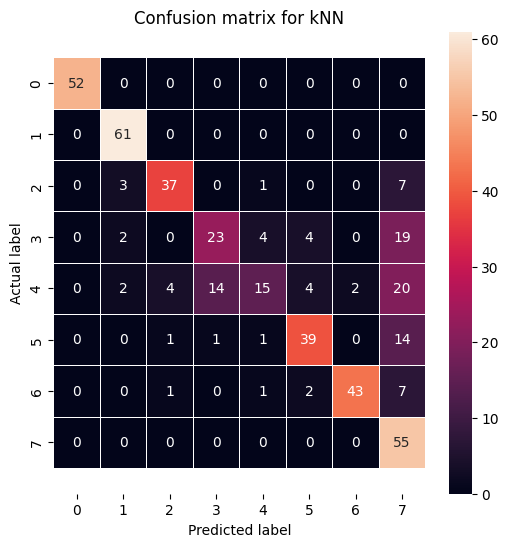

In [8]:
categories = np.unique(np.concatenate((y_test, y_pred)))
cnf_matrix = confusion_matrix(y_test, y_pred, labels = categories) # create a confusion matrix for our actual and predicted values
plt_confusion_matrix(cnf_matrix, categories, 'kNN')

 We can now calculate the accuracy of the model. This is simply the total number of correct predictions, i.e., the sum of the terms on the main diagonal of the confusion matrix, divided by the number of predictions, i.e., the sum of all the terms in the confusion matrix. In this case we have 4+26+18=48 correct predictions, and 133 total predictions. Therefore the accuracy in this case is 0.361. For a very good model the accuracy will approach 1, whereas for a very poor model the accuracy will approach 0.

In [9]:
evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, 'kNN'))

In [10]:
pd.DataFrame(evaluate_models).set_index('Step')

,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
Step,,,,,
kNN,0.7633,0.7198,0.7672,0.7198,0.7041


## **Deep Learning**

In [11]:
# Initial Setup
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

X = df.iloc[:, 2:-1].values
y = df['OutcomeScore'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN/RNN/LSTM (adding timestep dimension)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

X_train, X_test, X_train_reshaped, X_test_reshaped, y_train, y_test = train_test_split(
    X_scaled, X_reshaped, y_categorical, test_size=0.2, random_state=42)

### **Convolutional Neural Network**

In [12]:
# Create CNN model
cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')  # 9 classes (0-8)
])

cnn_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train CNN
cnn_history = cnn_model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.4024 - loss: 1.7198 - val_accuracy: 0.6264 - val_loss: 1.6438
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.6419 - loss: 0.9527 - val_accuracy: 0.6105 - val_loss: 1.5742
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.6341 - loss: 0.8825 - val_accuracy: 0.5900 - val_loss: 1.4933
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6540 - loss: 0.8719 - val_accuracy: 0.6355 - val_loss: 1.3887
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7031 - loss: 0.7588 - val_accuracy: 0.6469 - val_loss: 1.2882
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.6973 - loss: 0.7237 - val_accuracy: 0.6173 - val_loss: 1.1837
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7297 - loss: 0.6651 - val_accuracy: 0.6310 - val_loss: 1.0942
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7034 - loss: 0.7122 - val_accurac

In [13]:
rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),

    SimpleRNN(64),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])

rnn_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

rnn_history = rnn_model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.2320 - loss: 1.9993 - val_accuracy: 0.3371 - val_loss: 1.8534
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.4200 - loss: 1.5462 - val_accuracy: 0.4328 - val_loss: 1.5392
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.4815 - loss: 1.4181 - val_accuracy: 0.4055 - val_loss: 1.5882
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5047 - loss: 1.2939 - val_accuracy: 0.5057 - val_loss: 1.3406
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5305 - loss: 1.2255 - val_accuracy: 0.4966 - val_loss: 1.2442
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.5505 - loss: 1.1364 - val_accuracy: 0.5194 - val_loss: 1.1996
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.5645 - loss: 1.1020 - val_accuracy: 0.5923 - val_loss: 1.1103
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5553 - loss: 1.1256 - val_accuracy: 0.5649

In [14]:
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1), dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),

    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])

lstm_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

lstm_history = lstm_model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 590ms/step - accuracy: 0.1660 - loss: 2.1520 - val_accuracy: 0.2255 - val_loss: 2.0740
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 540ms/step - accuracy: 0.2278 - loss: 1.9785 - val_accuracy: 0.1321 - val_loss: 2.0657
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 565ms/step - accuracy: 0.2771 - loss: 1.8882 - val_accuracy: 0.2665 - val_loss: 2.0583
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.2887 - loss: 1.8350 - val_accuracy: 0.2210 - val_loss: 2.0400
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.3018 - loss: 1.7967 - val_accuracy: 0.2301 - val_loss: 2.0423
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.3533 - loss: 1.7053 - val_accuracy: 0.2551 - val_loss: 2.0265
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 561ms/step - accuracy: 0.3405 - loss: 1.7117 - val_accuracy: 0.2733 - val_loss: 2.0081
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.3438 - loss: 1.6817 - 

In [15]:
# Initialize a list to store all evaluation results
evaluation_results = []

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Evaluate a model and store results in a list.

    Args:
        model: The trained model to evaluate
        X_train: Training features
        y_train: Training labels (one-hot encoded)
        X_test: Test features
        y_test: Test labels (one-hot encoded)
        model_name: Name of the model for identification
    """
    # Convert one-hot encoded labels back to class indices
    y_train_classes = np.argmax(y_train, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Make predictions and convert to class indices
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # If model outputs probabilities, take argmax
    if y_train_pred.ndim > 1 and y_train_pred.shape[1] > 1:
        y_train_pred = np.argmax(y_train_pred, axis=1)
        y_test_pred = np.argmax(y_test_pred, axis=1)

    # Get classification reports
    train_report = classification_report(y_train_classes, y_train_pred, output_dict=True, zero_division=0)
    test_report = classification_report(y_test_classes, y_test_pred, output_dict=True, zero_division=0)

    # Store results
    result = {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train_classes, y_train_pred),
        'Test Accuracy': accuracy_score(y_test_classes, y_test_pred),
        'Precision': test_report['weighted avg']['precision'],
        'Recall': test_report['weighted avg']['recall'],
        'F1-Score': test_report['weighted avg']['f1-score'],
    }

    evaluation_results.append(result)

    # Print detailed report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test_classes, y_test_pred))

    return result

In [16]:
evaluate_model(cnn_model, X_train_reshaped, y_train, X_test_reshaped, y_test, "CNN")
evaluate_model(rnn_model, X_train_reshaped, y_train, X_test_reshaped, y_test, "RNN")
evaluate_model(lstm_model, X_train_reshaped, y_train, X_test_reshaped, y_test, "LSTM")

# Convert results to DataFrame for better visualization
pd.DataFrame(evaluation_results)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

CNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       0.95      1.00      0.98        61
           2       0.90      0.75      0.82        48
           3       0.49      0.35      0.40        52
           4       0.56      0.33      0.41        61
           5       0.84      0.64      0.73        56
           6       0.98      0.80      0.88        54
           7       0.45      1.00      0.62        55

    accuracy                           0.73       439
   macro avg       0.77      0.73      0.73       439
weighted avg       0.77      0.73      0.73       439

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

RNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       0.84  

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
0,CNN,0.798631,0.731207,0.767145,0.731207,0.726881
1,RNN,0.657730,0.644647,0.686433,0.644647,0.606889
2,LSTM,0.619509,0.601367,0.606151,0.601367,0.555826
